In [1]:
import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Source: https://www.geeksforgeeks.org/machine-learning/implementation-of-a-cnn-based-image-classifier-using-pytorch/

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

normalize_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [3]:
test_path = './catdog_data/test'
train_path = './catdog_data/train'
validation_path = './catdog_data/validation'

train_data = ImageFolder(root = train_path, transform = train_transform)
test_data = ImageFolder(root = test_path, transform = normalize_transform)
validation_data = ImageFolder(root = validation_path, transform = normalize_transform)

In [4]:
batch_size = 64

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

validation_dataloader = DataLoader(
    dataset = validation_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

print('Number of training batches: ', len(train_dataloader))
print('Number of validation batches: ', len(validation_dataloader))
print('Number of testing batches: ', len(test_dataloader))

Number of training batches:  32
Number of validation batches:  10
Number of testing batches:  7


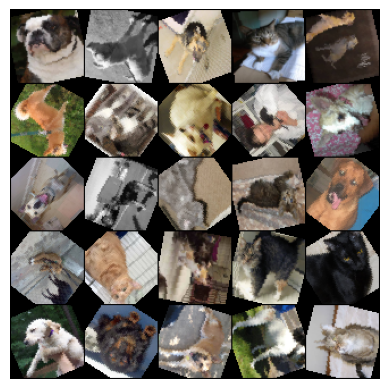

In [5]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [36]:
class CNN(nn.Module):
    def __init__(self, activation_function):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            activation_function,
            nn.MaxPool2d(kernel_size = 2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            activation_function,
            nn.MaxPool2d(kernel_size = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.MaxPool2d(kernel_size = 2)
        )

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 2)
        self.act = activation_function
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.act(self.fc1(out))
        out = self.fc2(out)
        return out
def train_epoch(model, dataloader, criterion, optimizer, device, regularization_type=None, lambda_reg=0.01):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        # Apply manual regularization if requested
        if regularization_type == 'L1':
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += lambda_reg * l1_norm
        elif regularization_type == 'L2':
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss += lambda_reg * l2_norm

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = val_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, device, early_stopping,
                regularization_type=None, lambda_reg=0.01, epochs=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device,
                                            regularization_type, lambda_reg)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"| Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
              f"| Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses, train_accs, val_accs

class EarlyStopping:
    def __init__(self, patience = 5, delta = 0, min_epochs = 10, verbose = False):
        self.patience = int(patience)
        self.delta = float(delta)
        self.min_epochs = int(min_epochs)
        self.verbose = bool(verbose)

        self.best_loss = float("inf")
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None
        self.epoch_count = 0

    def __call__(self, val_loss, model):
        self.epoch_count += 1

        is_improvement = val_loss < (self.best_loss - self.delta)

        if is_improvement:
            self.best_loss = val_loss
            self.best_model_state = {k: v.cpu().clone for k, v in model.state_dict().items()}
            self.counter = 0
            if self.verbose:
                print(f"Improved validation loss to {val_loss:.4f} at epoch {self.epoch_count}. Reset counter.")
            return

        if self.epoch_count >= self.min_epochs:
            self.counter += 1
            if self.verbose:
                print(F"No improvement ({self.counter}/self.patience) at epoch {self.epoch_count}.")
            if self.counter >= self.patience:
                self.early_stop = True
        
        else:
            if self.verbose:
                print(f"No improvement at epoch {self.epoch_count}, but warmup active (min_epochs = {self.min_epochs}).")

    def load_best_model(self, model, device = None):
        if self.best_model_state is None:
            raise RuntimeError("No best model state has been saved.")
        state = self.best_model_state
        if device is not None:
            # move tensors to device
            state = {k: v.to(device) for k, v in state.items()}
        model.load_state_dict(state)

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='x')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(val_accs, label='Val Accuracy', marker='x')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch [1/40] | Train Loss: 3.9913 | Val Loss: 0.7149 | Train Acc: 52.75% | Val Acc: 50.00%
Improved validation loss to 0.7149 at epoch 1. Reset counter.
Epoch [2/40] | Train Loss: 1.9275 | Val Loss: 0.6740 | Train Acc: 58.80% | Val Acc: 60.83%
Improved validation loss to 0.6740 at epoch 2. Reset counter.
Epoch [3/40] | Train Loss: 1.4302 | Val Loss: 0.6660 | Train Acc: 58.10% | Val Acc: 60.00%
No improvement at epoch 3, but warmup active (min_epochs = 10).
Epoch [4/40] | Train Loss: 1.2885 | Val Loss: 0.6939 | Train Acc: 59.45% | Val Acc: 58.50%
No improvement at epoch 4, but warmup active (min_epochs = 10).
Epoch [5/40] | Train Loss: 1.2002 | Val Loss: 0.6915 | Train Acc: 62.90% | Val Acc: 58.83%
No improvement at epoch 5, but warmup active (min_epochs = 10).
Epoch [6/40] | Train Loss: 1.1866 | Val Loss: 0.6645 | Train Acc: 62.85% | Val Acc: 61.33%
No improvement at epoch 6, but warmup active (min_epochs = 10).
Epoch [7/40] | Train Loss: 1.1464 | Val Loss: 0.7119 | Train Acc: 64.20% |

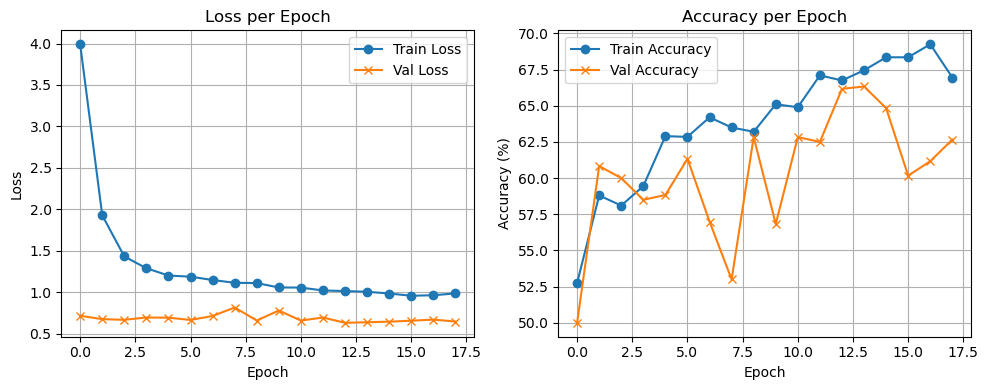

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(nn.SiLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
early_stopping = EarlyStopping(patience = 5, delta = 0.01, min_epochs = 10, verbose = True)


train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_dataloader,
    validation_dataloader,
    criterion,
    optimizer,
    device,
    early_stopping,
    regularization_type='L1',  # or 'L2' or None
    lambda_reg=0.001,          # smaller is often better for L1
    epochs=40
)

plot_metrics(train_losses, val_losses, train_accs, val_accs)

Epoch [1/40] | Train Loss: 3.7900 | Val Loss: 0.6874 | Train Acc: 55.35% | Val Acc: 55.00%
Epoch [2/40] | Train Loss: 3.1598 | Val Loss: 0.6721 | Train Acc: 60.65% | Val Acc: 57.67%
Epoch [3/40] | Train Loss: 2.8093 | Val Loss: 0.6531 | Train Acc: 63.70% | Val Acc: 64.17%
Epoch [4/40] | Train Loss: 2.5947 | Val Loss: 0.6897 | Train Acc: 65.25% | Val Acc: 59.67%
Epoch [5/40] | Train Loss: 2.4399 | Val Loss: 0.6890 | Train Acc: 65.05% | Val Acc: 61.67%
Epoch [6/40] | Train Loss: 2.3065 | Val Loss: 0.6504 | Train Acc: 63.90% | Val Acc: 62.83%
Epoch [7/40] | Train Loss: 2.1711 | Val Loss: 0.6484 | Train Acc: 65.15% | Val Acc: 64.50%
Epoch [8/40] | Train Loss: 2.0387 | Val Loss: 0.6981 | Train Acc: 67.60% | Val Acc: 58.67%
Epoch [9/40] | Train Loss: 1.9411 | Val Loss: 0.6416 | Train Acc: 67.75% | Val Acc: 66.00%
Epoch [10/40] | Train Loss: 1.8341 | Val Loss: 0.6343 | Train Acc: 68.70% | Val Acc: 64.00%
Epoch [11/40] | Train Loss: 1.7633 | Val Loss: 0.6457 | Train Acc: 66.40% | Val Acc: 61.8

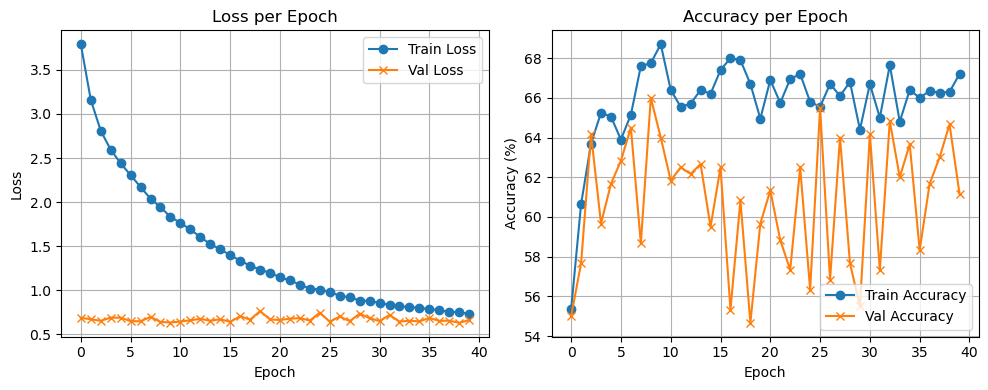

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(nn.SiLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_dataloader,
    validation_dataloader,
    criterion,
    optimizer,
    device,
    regularization_type='L2',  # or 'L2' or None
    lambda_reg=0.01,          # smaller is often better for L1
    epochs=40
)

plot_metrics(train_losses, val_losses, train_accs, val_accs)